# Complicance and Other Checks
This notebook ensures that the `UncertaintyForest` estimator is `sklearn`-compliant, and consistent with Richard's code. These checks will be incorporated into tests later.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from uncertainty_forest.uncertainty_forest import UncertaintyForest
from scipy.stats import norm
from scipy.integrate import quad

# Manual forest generation.
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import math

## Check that Conditional Entropy estimate is consistent with Richard's code.

In [2]:
def generate_data(n, d, mu = 1):
    n_1 = np.random.binomial(n, .5) # number of class 1
    mean = np.zeros(d)
    mean[0] = mu
    X_1 = np.random.multivariate_normal(mean, np.eye(d), n_1)
    
    X = np.concatenate((X_1, np.random.multivariate_normal(-mean, np.eye(d), n - n_1)))
    y = np.concatenate((np.repeat(1, n_1), np.repeat(-1, n - n_1)))
  
    return X, y

def split_train_eval(X, y, frac_eval):
    
    if frac_eval == 0:
        return X, y, [], []
    
    n = len(y)
    n_eval = int(np.floor(frac_eval*n))
    eval_indices = np.random.choice(np.arange(n), size = n_eval, replace = False)
    X_eval = X[eval_indices, :]
    y_eval = y[eval_indices]
    X = np.delete(X, eval_indices, axis = 0)
    y = np.delete(y, eval_indices, axis = 0)
    
    return X, y, X_eval, y_eval

In [ ]:
# Plot data.

In [3]:
def true_cond_entropy(mu, base = 2.0):
    def func(x):
        p = 0.5 * norm.pdf(x, mu, 1) + 0.5 * norm.pdf(x, -mu, 1)
        return -p * np.log(p) / np.log(base)
    
    H_X = quad(func, -20, 20)
    H_XY = 0.5*(1.0 + np.log(2 * np.pi)) / np.log(base)
    H_Y = np.log(2.0) / np.log(base)
    # I_XY = H_X - H_XY = H_Y - H_YX
    return H_Y - H_X[0] + H_XY

In [4]:
def cef_estimate(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1, max_features = 1.):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = math.ceil(int(math.sqrt(X.shape[1])))),
                              n_estimators = n_estimators,
                              max_samples= max_samples,
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree in model:
        # get out of bag indicies
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))

        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])

        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])

        class_probs.tolist()
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[eval_indices])])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[eval_indices] += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

def uncertainty_forests_estimate(X, y, n_estimators = 300, eval_split_size = .33,
                                                  subsample_size = 0.5,
                                                  depth = 30,
                                                  min_samples_leaf = 1):
    """
    Uncertainty forest algorithm for estimating conditional entropy.
    The major steps are as follows:
    1. Split samples into EVAL and TRAIN according to eval_split_size
    2. Get subsample s from TRAIN samples according to subsample_size
    3. Split s into two partitions: STRUCT and PROB
    4. Train decision forest on STRUCT (this is just sklearn's fit function)
    5. For each tree in forest:
        i) Use PROB samples to compute probabilites in each leaf node
        ii) Perform robust finite sampling on posteriors computed by PROB samples
        iii) Use posterior to get probability that eval sample fell in leaf node
        iv) Weight eval sample probabilities by number of samples in leaf node (get class counts)
    6. Compute probabilities from class counts over entire forest
    7. Use probabilities to compute conditional entropies
    8. Return average conditional entropy over all eval samples


    Parameters
    ----------
    X: array-like
        Training samples.

    y: list
        Class labels for training samples.

    n_estimators: int
        Number of trees in forest.

    eval_split_size: float between 0 and 1
        Percent of samples to include in evaluation partition.

    subsample_size: float between 0 and 1
        Percent of non eval samples to use for a tree (subsample forms PROB and STRUCT samples).

    depth: int
        Maximum depth in tree.

    min_samples_leaf
        Minimum number of samples in node to be considered leaf.

    Returns
    -------
    Conditional entropy estimate
    """

    # split samples into eval and non eval
    # X_train, X_eval, y_train, _ = train_test_split(X, y, test_size=eval_split_size)
    X_train, y_train, X_eval, y_eval = split_train_eval(X, y, eval_split_size) # Ronak version.

    max_samples = int(X_train.shape[0]*subsample_size)
    split_samples = max_samples // 2
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth,
                              min_samples_leaf = min_samples_leaf,
                              # set default maximum features to sqrt(total features)
                              max_features = math.ceil(int(math.sqrt(X.shape[1])))),
                              n_estimators = n_estimators,
                              max_samples= split_samples,
                              bootstrap = True)

    model.fit(X_train, y_train)
    # Matrix used to compute final estimate
    # Each entry is total number of PROB nodes of class y that fell into
    # the same leaf nodes that a x_eval sample fell into.
    class_counts = np.zeros((X_eval.shape[0], model.n_classes_))
    for tree in model:

        # get total unused samples indices
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        # shuffle unused sample indices
        np.random.shuffle(unsampled_indices)
        # take split_samples amount as PROB indices (honest sampling)
        prob_indices = unsampled_indices[:split_samples]

        # get all node counts in tree
        node_counts = tree.tree_.n_node_samples

        # use PROB samples to compute posterior for tree

        # NOTE: this considers probabilities for all nodes in the tree.
        # However, only leaf nodes will have relevant values
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        # for each leaf, count number of samples with each class label that fell into leaf
        # NOTE: unused leaf nodes will have probability 0 for every class

        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1

        # divide each leaf node by number of total samples that fell into leaf node
        row_sums = posterior_class_counts.sum(axis=1)
        # handle divide by 0 errors
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])

        # perform robust finite sampling
        class_probs = robust_finite_sampling(class_probs, row_sums, model.n_classes_)

        # Get probabilities from EVAL samples for final estimate
        # Weigh the probailities by number of samples in leaf node

        # Get leaf nodes counts for each sample in EVAL
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X_eval)])
        # get probability for eval samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X_eval)]
        eval_class_probs = np.array(eval_class_probs)
        # Get total elements
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts += elems
    # calculate p(y|X = x) for all x's
    forest_probabilities = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(forest_probabilities)*forest_probabilities, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    # return sample mean
    return np.mean(entropies)


def robust_finite_sampling(class_probs, row_sums, n_classes):
    where_0 = np.argwhere(class_probs == 0)
    for elem in where_0:
        class_probs[elem[0], elem[1]] = 1/(n_classes*row_sums[elem[0], None])
    where_1 = np.argwhere(class_probs == 1)
    for elem in where_1:
        class_probs[elem[0], elem[1]] = 1 - (n_classes - 1)/(n_classes*row_sums[elem[0], None])
    return class_probs.tolist()

np.warnings.filterwarnings('ignore')

In [11]:
mu = 1
d = 1
sample_sizes = 2*np.array([100, 200, 300, 400])
num_trials = 5
n_estimators = 300
base = np.exp(1)

In [12]:
richard_cef = np.zeros((len(sample_sizes), num_trials))
richard_uf = np.zeros((len(sample_sizes), num_trials))
ronak = np.zeros((len(sample_sizes), num_trials))

for i, n in enumerate(sample_sizes):
    print("Sample size:", n)
    for t in range(num_trials):
        X, y = generate_data(n, d, mu = mu)
        richard_cef[i, t] = cef_estimate(X, y, n_estimators = n_estimators)
        richard_uf[i, t] = uncertainty_forests_estimate(X, y, n_estimators = n_estimators)

        uf = UncertaintyForest(n_estimators = n_estimators, base = base)
        uf.fit(X, y)
        ronak[i, t] = uf.estimate_cond_entropy()

Sample size: 200
Sample size: 400
Sample size: 600
Sample size: 800


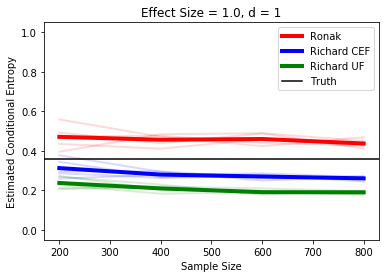

In [15]:
plt.plot(sample_sizes,
         np.log(2.0)*np.mean(ronak, axis = 1).flatten(), 
         label = 'Ronak', 
         linewidth = 4, 
         color = 'red')
for t in range(num_trials):
    plt.plot(sample_sizes, 
    np.log(2.0)*ronak[:, t].flatten(),  
    linewidth = 2, 
    color = 'red',
    alpha = 0.15)
plt.plot(sample_sizes,
         np.mean(richard_cef, axis = 1).flatten(), 
         label = 'Richard CEF', 
         linewidth = 4, 
         color = 'blue')
for t in range(num_trials):
    plt.plot(sample_sizes, 
    richard_cef[:, t].flatten(),  
    linewidth = 2, 
    color = 'blue',
    alpha = 0.15)
plt.plot(sample_sizes,
         np.mean(richard_uf, axis = 1).flatten(), 
         label = 'Richard UF', 
         linewidth = 4, 
         color = 'green')
for t in range(num_trials):
    plt.plot(sample_sizes, 
    richard_uf[:, t].flatten(),  
    linewidth = 2, 
    color = 'green',
    alpha = 0.15)

truth = true_cond_entropy(mu, base = np.exp(1))
plt.axhline(y = truth, linestyle = '-', color = "black", label = "Truth")

plt.xlabel("Sample Size")
plt.ylabel("Estimated Conditional Entropy")
plt.title("Effect Size = %.1f, d = %d" % (mu, d))
plt.legend(loc = "upper right")
plt.ylim(ymin = -0.05, ymax = 1.05)
plt.show()